In [1]:
%reload_ext autoreload
%autoreload 2
from sklearn.calibration import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from scipy import stats
from common import load_data, baseline_results_wc
from sklearn.metrics import classification_report


In [5]:
# Data Loading
random_state = 1234
test_size = 0.40
pareto_cutoff = 0.5
rank_by_domination_count = True
system = "x264"

performances = []
# performances = ["fps", "cpu"]
# performances = ["kbs", "fps"]
# performances = ["kbs", "etime"]

(
    perf_matrix_initial,
    input_features,
    config_features,
    all_performances,
    input_preprocessor,
    config_preprocessor,
) = load_data(system=system, data_dir="../data", input_properties_type="tabular")

if len(performances) == 0:
    performances = all_performances

nmdf = (
    perf_matrix_initial[["inputname"] + performances]
    .groupby("inputname", as_index=True)
    .transform(lambda x: (x - x.min()) / (x.max() - x.min()))
)
nmdf["worst_case_performance"] = nmdf[performances].max(axis=1)
perf_matrix = pd.merge(
    perf_matrix_initial, nmdf, suffixes=("_raw", None), left_index=True, right_index=True
)
perf_matrix["rank"] = perf_matrix.groupby("inputname", group_keys=False).apply(
    lambda x: x["worst_case_performance"].argsort()+1
)
# We adjust the WCP by expressing it as the difference from the best WCP, i.e. the best WCP is always 0
perf_matrix["worst_case_performance_adjusted"] = (
    perf_matrix[["inputname", "worst_case_performance"]]
    .groupby("inputname", as_index=True)
    .transform(lambda x: x - x.min())
)

all_perf_raw = [f"{p}_raw" for p in performances]
all_perf_norm = [f"{p}" for p in performances]



# Split data
train_inp, test_inp = train_test_split(
    perf_matrix["inputname"].unique(),
    test_size=test_size,
    random_state=random_state,
)

# This is only to make our evaluation simpler
train_inp = sorted(train_inp)
test_inp = sorted(test_inp)

# Prepare baseline evaluation
icm = (
    perf_matrix[perf_matrix.inputname.isin(train_inp)][["inputname", "configurationID", "worst_case_performance"]]
    .sort_values(["inputname", "configurationID"])
    .set_index(["inputname", "configurationID"])
)
icm_ranked_measures = icm.groupby(
    "inputname"
).transform(  # Go from measured values to ranks within each input group
    lambda x: x.argsort()+1
)
icm["ranks"] = icm.groupby("inputname", group_keys=False).apply(
    lambda x: x["worst_case_performance"].argsort()+1
)


icm_test = (
    perf_matrix[~perf_matrix.inputname.isin(train_inp)][["inputname", "configurationID", "worst_case_performance"]]
    .sort_values(["inputname", "configurationID"])
    .set_index(["inputname", "configurationID"])
)
icm_test["ranks"] = icm_test.groupby("inputname", group_keys=False).apply(
    lambda x: x["worst_case_performance"].argsort()+1
)

# Full dataset of input features + config features that are in the first rank
dataset_baselines = icm.join(config_features).join(input_features).reset_index()

def eval_prediction(pred_cfg_test):
    inp_pred_map = pd.DataFrame(
        zip(test_inp, pred_cfg_test), columns=["inputname", "configurationID"]
    )
    return icm_test.merge(inp_pred_map, on=["inputname", "configurationID"])["worst_case_performance"].mean()


/tmp/ipykernel_25184/2389130206.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  perf_matrix["rank"] = perf_matrix.groupby("inputname", group_keys=False).apply(


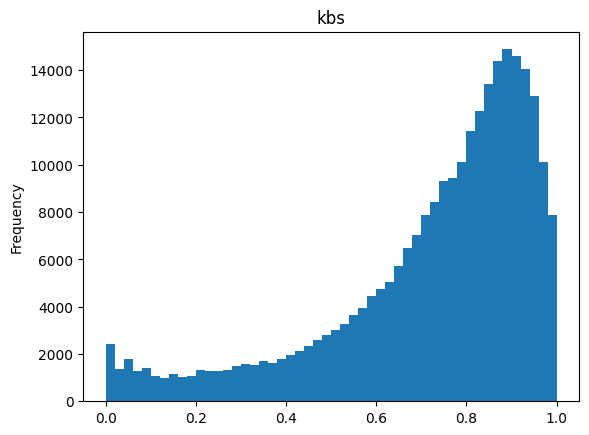

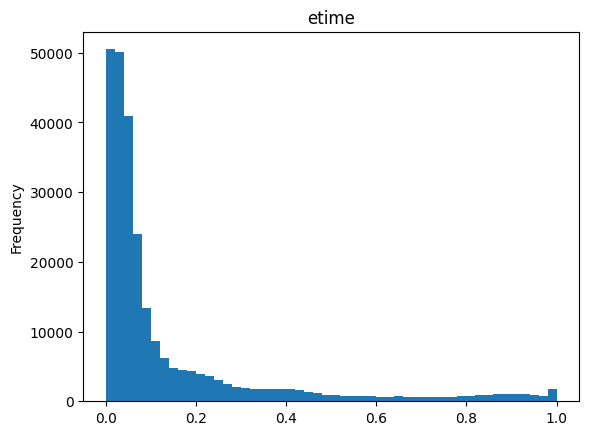

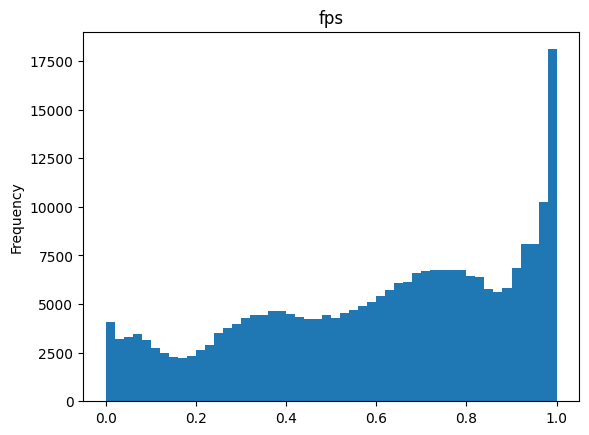

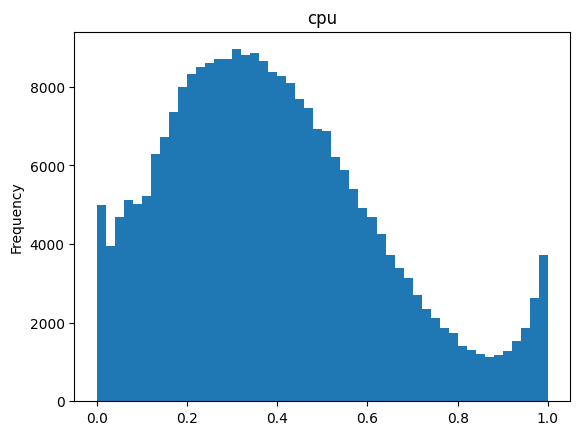

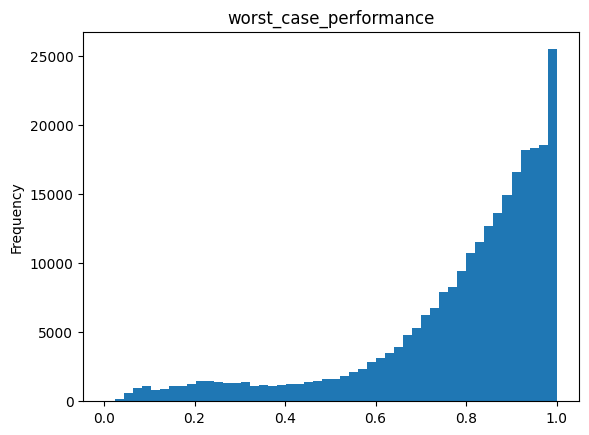

In [6]:
for c in performances + ["worst_case_performance"]:
    perf_matrix[c].plot.hist(bins=50)
    plt.title(c)
    plt.show()

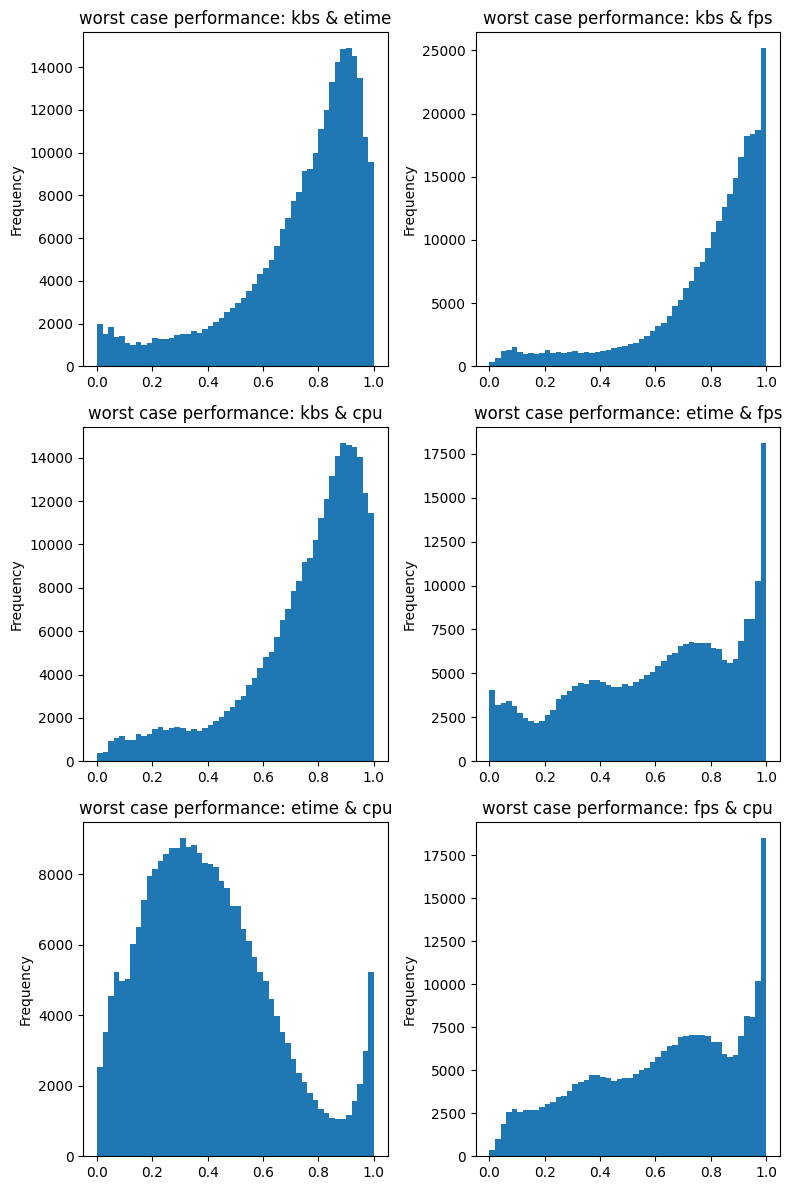

In [8]:
# Calculate number of combinations for subplot grid
combs = list(itertools.combinations(performances, 2))
n = len(combs)
rows = int(np.ceil(np.sqrt(n)))
cols = int(np.ceil(n/rows))

fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3.5*rows))
axes = axes.flatten()

for i, (c1, c2) in enumerate(combs):
    perf_matrix[[c1, c2]].max(axis=1).plot.hist(bins=50, ax=axes[i])
    axes[i].set_title(f"worst case performance: {c1} & {c2}")

# Hide any empty subplots
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


In [23]:
# Baseline preparation


baseline_results_wc(icm, icm_ranked_measures, icm_test, dataset_baselines, config_features, verbose=True)

Best WCP per input: 0.01+-0.02
Average WCP per input: 0.72+-0.07
Average WCP of the overall best configuration: 0.91+-0.06
Average WCP of the most common configuration: 0.19+-0.17
Average WCP of the best configuration for all metrics: 0.91+-0.06
Average WCP of random configuration: 0.66+-0.30


{'best': [0.013940334389563498, 0.016687982187171466],
 'average': [0.7228439484578479, 0.06527311094222643],
 'overall': [0.9068289342638488, 0.061962443165769876],
 'metric': [0.9068289342638488, 0.061962443165769876],
 'common': [0.19000851337836863, 0.16942193209370623],
 'random': [0.6557433458402222, 0.29741722023487766]}

shapes (772, 21) (772,) (515, 21) (515,)


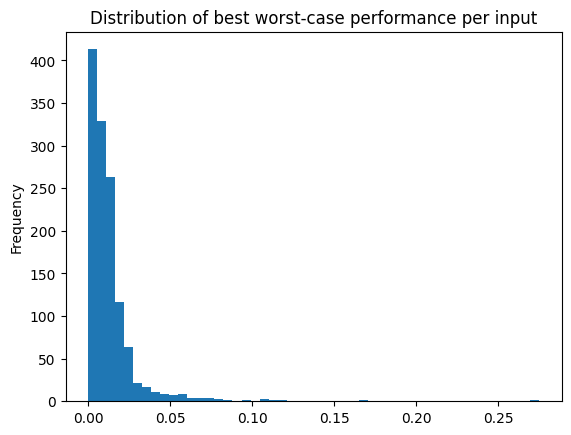

In [24]:
# Single configuration dataset
# We find the best configuration per input
dataset = (
    perf_matrix.groupby('inputname')
    .apply(lambda x: x.loc[x['worst_case_performance'].idxmin()], include_groups=False)
    .reset_index()
)

train_perf = dataset[dataset.inputname.isin(train_inp)].copy()
test_perf = dataset[dataset.inputname.isin(test_inp)]

X = input_preprocessor.fit_transform(
    train_perf[
        input_features.columns
    ]
)
y = train_perf["configurationID"]

X_test = input_preprocessor.transform(
    test_perf[  
        input_features.columns
    ]
)
y_test = test_perf["configurationID"]
print("shapes", X.shape, y.shape, X_test.shape, y_test.shape)

# This is the best worst-case performance per input
dataset.worst_case_performance.plot.hist(bins=50)
plt.title("Distribution of best worst-case performance per input")
plt.show()

In [25]:
clf = RandomForestClassifier(n_estimators=10, random_state=random_state)
clf.fit(X, y)
print("scores", clf.score(X, y), clf.score(X_test, y_test))
pred_cfg_test = clf.predict(X_test)

print(
    f"Avg. WCP on test inputs {eval_prediction(pred_cfg_test):.2f}"
    )
print(classification_report(y_test, clf.predict(X_test)))


scores 0.9857512953367875 0.537864077669903
Avg. WCP on test inputs 0.09
              precision    recall  f1-score   support

          13       0.00      0.00      0.00         2
          17       0.00      0.00      0.00         1
          18       0.00      0.00      0.00         8
          21       0.65      0.80      0.72       166
          22       0.38      0.46      0.42        76
          28       0.33      0.19      0.24        16
          29       0.00      0.00      0.00         1
          31       0.45      0.50      0.47        98
          32       0.57      0.46      0.51       112
          33       0.33      0.11      0.17         9
          90       0.60      0.38      0.46         8
         100       0.50      0.06      0.11        17
         106       0.00      0.00      0.00         1

    accuracy                           0.54       515
   macro avg       0.29      0.23      0.24       515
weighted avg       0.52      0.54      0.52       515



/home/helge/Sandbox/resist/partial-configuration/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/helge/Sandbox/resist/partial-configuration/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/helge/Sandbox/resist/partial-configuration/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

In [26]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=(8,8,8,), max_iter=1000,random_state=random_state)
clf.fit(X, y)
print("scores", clf.score(X, y), clf.score(X_test, y_test))
pred_cfg_test = clf.predict(X_test)

print(
    f"Avg. WCP on test inputs {eval_prediction(pred_cfg_test):.2f}"
    )
print(classification_report(y_test, clf.predict(X_test)))


scores 0.41968911917098445 0.4
Avg. WCP on test inputs 0.17
              precision    recall  f1-score   support

          13       0.00      0.00      0.00         2
          17       0.00      0.00      0.00         1
          18       0.00      0.00      0.00         8
          21       0.44      0.86      0.58       166
          22       0.33      0.03      0.05        76
          28       0.00      0.00      0.00        16
          29       0.00      0.00      0.00         1
          31       0.29      0.09      0.14        98
          32       0.35      0.47      0.40       112
          33       0.00      0.00      0.00         9
          90       0.00      0.00      0.00         8
         100       0.00      0.00      0.00        17
         106       0.00      0.00      0.00         1

    accuracy                           0.40       515
   macro avg       0.11      0.11      0.09       515
weighted avg       0.32      0.40      0.31       515



/home/helge/Sandbox/resist/partial-configuration/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/helge/Sandbox/resist/partial-configuration/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/helge/Sandbox/resist/partial-configuration/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
clf = LogisticRegression(max_iter=1_000, dual=True, solver="liblinear")

scaler = StandardScaler()
X2 = scaler.fit_transform(X)
X_test2 = scaler.transform(X_test)
clf.fit(X2, y)
print("scores", clf.score(X2, y), clf.score(X_test2, y_test))
pred_cfg_test = clf.predict(X_test2)

print(
    f"Avg. WCP on test inputs {eval_prediction(pred_cfg_test):.2f}"
    )
print(classification_report(y_test, clf.predict(X_test2)))


scores 0.6075129533678757 0.5592233009708738
Avg. WCP on test inputs 0.09
              precision    recall  f1-score   support

          13       0.00      0.00      0.00         2
          17       0.00      0.00      0.00         1
          18       0.00      0.00      0.00         8
          21       0.65      0.81      0.72       166
          22       0.40      0.43      0.42        76
          28       0.50      0.06      0.11        16
          29       0.00      0.00      0.00         1
          31       0.49      0.56      0.52        98
          32       0.58      0.57      0.57       112
          33       0.00      0.00      0.00         9
          90       0.00      0.00      0.00         8
         100       1.00      0.06      0.11        17
         106       0.00      0.00      0.00         1

    accuracy                           0.56       515
   macro avg       0.28      0.19      0.19       515
weighted avg       0.54      0.56      0.53       515



/home/helge/Sandbox/resist/partial-configuration/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/helge/Sandbox/resist/partial-configuration/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/helge/Sandbox/resist/partial-configuration/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

In [28]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=random_state)
clf.fit(X, y)
pred_cfg_test = clf.predict(X_test)
print(clf.score(X, y), clf.score(X_test, y_test))
print("Avg. WCP", eval_prediction(pred_cfg_test))
print(classification_report(y_test, clf.predict(X_test)))

1.0 0.47766990291262135
Avg. WCP 0.10676096571051108
              precision    recall  f1-score   support

          13       0.50      0.50      0.50         2
          17       0.00      0.00      0.00         1
          18       0.00      0.00      0.00         8
          21       0.74      0.69      0.71       166
          22       0.28      0.28      0.28        76
          23       0.00      0.00      0.00         0
          28       0.08      0.12      0.10        16
          29       0.00      0.00      0.00         1
          31       0.42      0.51      0.46        98
          32       0.47      0.41      0.44       112
          33       0.13      0.22      0.17         9
          52       0.00      0.00      0.00         0
          90       0.64      0.88      0.74         8
         100       0.50      0.12      0.19        17
         106       0.00      0.00      0.00         1

    accuracy                           0.48       515
   macro avg       0.25    

/home/helge/Sandbox/resist/partial-configuration/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/helge/Sandbox/resist/partial-configuration/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/helge/Sandbox/resist/partial-configuration/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior

In [33]:
for depth in range(1, 20):
    clf = DecisionTreeClassifier(random_state=random_state, max_depth=depth)
    clf.fit(X, y)
    pred_cfg_test = clf.predict(X_test)
    print(f"WCP@{depth}: {eval_prediction(pred_cfg_test):.3f}")

WCP@1: 0.141
WCP@2: 0.102
WCP@3: 0.111
WCP@4: 0.091
WCP@5: 0.088
WCP@6: 0.088
WCP@7: 0.096
WCP@8: 0.095
WCP@9: 0.097
WCP@10: 0.097
WCP@11: 0.103
WCP@12: 0.103
WCP@13: 0.100
WCP@14: 0.104
WCP@15: 0.103
WCP@16: 0.104
WCP@17: 0.105
WCP@18: 0.105
WCP@19: 0.107


In [37]:
clf.tree_.n_classes

array([18])

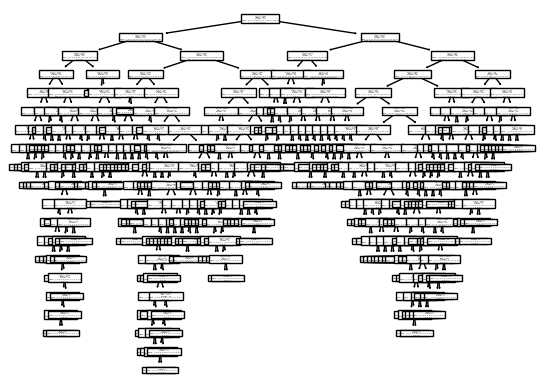

In [29]:
from sklearn import tree
tree.plot_tree(clf)
plt.show()


In [11]:
## Multiple configurations per input

# The threshold must be at least this high to include all inputs
min_wc_perf_threshold = perf_matrix[["inputname", "worst_case_performance"]].groupby("inputname").min().max().item()
wc_perf_threshold = 0.30


# worse_inputs = perf_matrix[perf_matrix["worst_case_performance"] >= wc_perf_threshold]["inputname"]
# # TODO Fix such that for missing inputs, we take the next best configuration (even if it's above the threshold)

# assert wc_perf_threshold >= min_wc_perf_threshold, "wc_perf_threshold not high enough"

# TODO We don't need this encoder, but we need something for the apply function in the dataset_below groupby
enc = LabelEncoder()
enc.fit(perf_matrix["configurationID"].tolist())

# This is the largest minimal WCP over all inputs
# If we set a general threshold it must be at least this high, otherwise we exclude inputs
min_wc_perf_threshold = perf_matrix[["inputname", "worst_case_performance"]].groupby("inputname").min().max().item()
wc_perf_threshold = 0.03

is_below_threshold = perf_matrix[perf_matrix["worst_case_performance"] < wc_perf_threshold].inputname.unique()
all_above_threshold = set(perf_matrix[perf_matrix["worst_case_performance"] >= wc_perf_threshold].inputname.unique()) - set(is_below_threshold)

# We find the best configurations per input
dataset_below = (
    perf_matrix[perf_matrix["worst_case_performance"] < wc_perf_threshold].groupby('inputname')["configurationID"].apply(enc.transform)
)
dataset_above = (
    perf_matrix[perf_matrix.inputname.isin(all_above_threshold)].groupby('inputname')
    .apply(lambda x: x.loc[x['worst_case_performance'].idxmin()], include_groups=False)["configurationID"].apply(lambda x: [x])
)

# (index/inputname, configurationIDs)
dataset = pd.concat((dataset_above, dataset_below)).sort_index().reset_index()



# num_cfg_per_input = 5  # alternative, but less useful?
# dataset = perf_matrix[perf_matrix.worst_case_performance < wc_perf_threshold]
# print(dataset.shape, dataset.inputname.nunique()/perf_matrix.inputname.nunique())
# enc = LabelEncoder()
# enc.fit(perf_matrix["configurationID"].tolist())
# # We find the best configurations per input
# dataset = (
#     perf_matrix.groupby('inputname')["configurationID"].apply(enc.transform).reset_index()
# )

train_perf = dataset[dataset.inputname.isin(train_inp)].copy()
test_perf = dataset[dataset.inputname.isin(test_inp)]

In [12]:
# wc_perf_mask = perf_matrix["worst_case_performance"] < wc_perf_threshold

# enc = LabelEncoder()
# enc.fit(perf_matrix[wc_perf_mask]["configurationID"].tolist())

# grouped_df = perf_matrix[wc_perf_mask].groupby("inputname")["configurationID"].apply(enc.transform).reset_index()
grouped_df = dataset
grouped_df

,inputname,configurationID
0,Animation_1080P-01b3,[31]
1,Animation_1080P-05f8,"[20, 30]"
2,Animation_1080P-0c4f,"[0, 12, 13, 14, 15, 16, 19, 23, 24, 27, 28, 30..."
3,Animation_1080P-0cdf,"[20, 27]"
4,Animation_1080P-18f5,[20]
...,...,...
1282,Vlog_720P-561e,"[0, 12, 13, 14, 15, 16, 19, 23, 24, 28, 30, 31]"
1283,Vlog_720P-5d08,[20]
1284,Vlog_720P-60f8,[20]
1285,Vlog_720P-6410,"[21, 32]"


<Axes: ylabel='Frequency'>

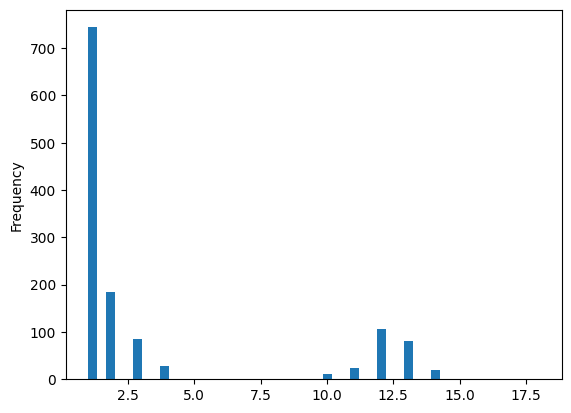

In [13]:
grouped_df["configurationID"].apply(len).plot.hist(bins=50)

In [14]:
input_features_with_cfgs = grouped_df.join(input_features, on="inputname")

train_mask = input_features_with_cfgs.inputname.isin(train_inp)

X_train = input_preprocessor.fit_transform(
    input_features_with_cfgs[train_mask][input_features.columns]
)
X_test = input_preprocessor.transform(
    input_features_with_cfgs[~train_mask][input_features.columns]
)

In [15]:
from common import DecisionTreeClassifierWithMultipleLabels

mlb = MultiLabelBinarizer()
binary_matrix = mlb.fit_transform(grouped_df["configurationID"])

# Create a new DataFrame with the binary matrix
binary_df = pd.DataFrame(
    binary_matrix, columns=mlb.classes_, index=grouped_df["inputname"]
)
y_train = binary_df.values[train_mask]
y_test = binary_df.values[~train_mask]

clf = DecisionTreeClassifierWithMultipleLabels(max_depth=X.shape[1])
clf.fit(X_train, y_train)
print("scores", clf.score(X_train, y_train), clf.score(X_test, y_test))
pred_cfg_test = enc.inverse_transform(clf.predict(X_test)).astype(int)
print(f"WCP {eval_prediction(pred_cfg_test)}")

scores 1.0 0.6077669902912621
WCP 0.4399156008005741


In [16]:
binary_df

,0,10,11,12,13,14,15,16,17,19,...,33,51,52,59,89,90,99,100,105,106
inputname,,,,,,,,,,,,,,,,,,,,,
Animation_1080P-01b3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Animation_1080P-05f8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Animation_1080P-0c4f,1,0,0,1,1,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
Animation_1080P-0cdf,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Animation_1080P-18f5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vlog_720P-561e,1,0,0,1,1,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
Vlog_720P-5d08,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Vlog_720P-60f8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
# TODO Evaluate decision tree size: it should be smaller for a larger wcp threshold
# TODO Change decision tree training to optimize
# TODO What's the best performance the configurations from the training set can achieve? / helps our internal evaluation of the method
# TODO How many configurations with very similar WCPs are there for the different inputs? -> make plot? heatmap, x input, y intensity per WCP bin
# TODO Statistical test vs best result (or all others?) / is it significantly higher?
# TODO Should we express the WCP as a percentage of the best WCP, e.g. MAPE over best possible WCP? That is, normalize WCP per input.

In [18]:
perf_matrix.groupby("inputname")["worst_case_performance"].agg(lambda x: (x < 0.05).sum()).max()

18

In [19]:
all_performances

['kbs', 'etime', 'fps', 'cpu']

In [20]:
import itertools
ap = []
for num_p in range(1, len(all_performances) + 1):
    ap.extend(list(map(list, itertools.combinations(all_performances, num_p))))

ap

[['kbs'],
 ['etime'],
 ['fps'],
 ['cpu'],
 ['kbs', 'etime'],
 ['kbs', 'fps'],
 ['kbs', 'cpu'],
 ['etime', 'fps'],
 ['etime', 'cpu'],
 ['fps', 'cpu'],
 ['kbs', 'etime', 'fps'],
 ['kbs', 'etime', 'cpu'],
 ['kbs', 'fps', 'cpu'],
 ['etime', 'fps', 'cpu'],
 ['kbs', 'etime', 'fps', 'cpu']]